# 理解した気持ちになるガウス過程

機械学習チーム・上間

## ガウス過程のうわさ

* 過学習しない
* ハイパーパラメータのチューニング不要(ベイズ最適化)
* 予測値だけでなく信頼度(?)も得られる
* 無限の隠れユニットを持つ深層学習と等価

## どうしたら理解した気持ちになるか

* 式を導出
* 実装
* 実際の問題に適用

*式を導出するだけでなく実装することで, 強みと弱みが分かる気がする*

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## こんな回帰の問題を考えてみる

* $y = \sin(x_1) + \cos(x_2) + \epsilon$ に基づく値 $y$ がある
* $x_1$, $x_2$ が観測されたとして, このデータから 値 $y$ を求めたい
* $\epsilon$ はノイズ

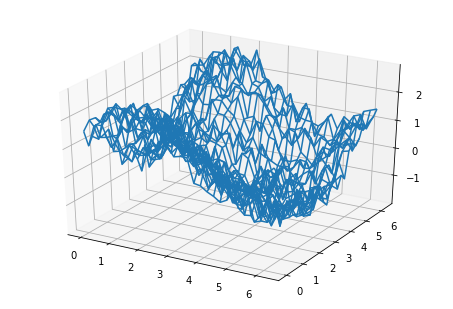

In [44]:
N = 30
X1, X2 = np.meshgrid(np.linspace(0, 2*np.pi, N), np.linspace(0, 2*np.pi, N))
X = np.c_[np.ravel(X1), np.ravel(X2)]

target = (np.sin(X[:,0])+np.cos(X[:,1])+np.random.rand(X.shape[0])).reshape(X1.shape)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X1, X2, target)

plt.show()




$\boldsymbol{y}=f(\boldsymbol{x})+\boldsymbol{\epsilon}$ ただし $f(\boldsymbol{x}) = \boldsymbol{xw^T}$

$\boldsymbol{y}$は(N, 1)のベクトル

$y_i$はスカラー

$\boldsymbol{X}$は(N, D)の行列

$\boldsymbol{x_i}$は(1, D)のベクトル

$\boldsymbol{w}$は(1, D)のベクトル

とおく

まずは, ある観測データ $\boldsymbol{X}$ が得られたとき, $\boldsymbol{y}$ を取る確率 = 事後分布 を求める

$\boldsymbol{y_i}$ は独立であり, 正規分布に基づくとすると

$$
\begin{align*}
p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w}) &= p(y_1|\boldsymbol{x_1},\boldsymbol{w}) \times p(y_2|\boldsymbol{x_2},\boldsymbol{w}) \times ... \times p(y_N|\boldsymbol{x_N},\boldsymbol{w})\\
&= \prod_{i=1}^N p(y_i|\boldsymbol{x_i},\boldsymbol{w})\\
&= \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}} \exp{\left(\frac{-(y_i-\boldsymbol{x_i}\boldsymbol{w^T})^2}{2\sigma^2}\right)}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \prod_{i=1}^N \exp{\left(\frac{-(y_i-\boldsymbol{x_i}\boldsymbol{w^T})^2}{2\sigma^2}\right)}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left( \sum_{i=1}^N \frac{-(y_i-\boldsymbol{x_i}\boldsymbol{w^T})^2}{2\sigma^2}\right)}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \left((y_1-\boldsymbol{x_1}\boldsymbol{w^T})^2+...+(y_N-\boldsymbol{x_N}\boldsymbol{w^T})^2\right) \right\}}\\
\end{align*}
$$

ここで, ベクトル $\boldsymbol{a}=(\begin{array}{cccc} a_1 & a_2 & ... &a_N \end{array} )$ のL2ノルムは $\|\boldsymbol{a}\| = \sqrt{a_1^2+a_2^2+...+a_N^2}$ なので

$a_1^2+a_2^2+...+a_N^2 = \|\boldsymbol{a}\|^2 = \|(\begin{array}{cccc} a_1 & a_2 & ... &a_N \end{array})\|^2$ とおいて

$$
\begin{align*}
p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w}) &= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \|\left(\begin{array}{ccc}y_1-\boldsymbol{x_1}\boldsymbol{w^T}&...&y_N-\boldsymbol{x_N}\boldsymbol{w^T}\end{array}\right)\|^2 \right\}}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \|(\begin{array}{ccc}y_1&...&y_N\end{array}) - (\begin{array}{ccc}\boldsymbol{x_1}\boldsymbol{w^T}&...&\boldsymbol{x_N}\boldsymbol{w^T}\end{array})\|^2 \right\}}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \|\boldsymbol{y^T} - \boldsymbol{w}(\begin{array}{ccc}\boldsymbol{x_1^T}&...&\boldsymbol{x_N^T}\end{array})\|^2 \right\}}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \|\boldsymbol{y^T} - \boldsymbol{w}\boldsymbol{X^T}\|^2 \right\}}
\end{align*}
$$

また, $\|\boldsymbol{a}\|^2=a_1^2+a_2^2+...+a_N^2 = \boldsymbol{a}\boldsymbol{a^T}$ と表せるので

$$
\begin{align*}
p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w}) &= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \left(\boldsymbol{y^T} - \boldsymbol{w}\boldsymbol{X^T}\right)\left(\boldsymbol{y^T} - \boldsymbol{w}\boldsymbol{X^T}\right)^T \right\}}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \left(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{w^T}\right)^T\left(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{w^T}\right) \right\}}\\
&= \left(\frac{1}{\left(\sqrt{2\pi}\right)^N\sqrt{|\sigma^2\boldsymbol{I}|}}\right) \exp{\left\{ -\frac{1}{2} \left(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{w^T}\right)^T \left(\sigma^2 \boldsymbol{I} \right)^{-1} \left(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{w^T}\right) \right\}}
\end{align*}
$$

よって,$\boldsymbol{y}$ の事後分布は平均$\boldsymbol{X}\boldsymbol{w^T}$ 分散$\sigma^2\boldsymbol{I}$ の多次元ガウス分布となる

ちなみに多次元ガウス分布は以下の式で表せる

$$
N(\boldsymbol{x}|\boldsymbol{\mu},\boldsymbol{\Sigma}) = \frac{1}{\left(\sqrt{2\pi}\right)^N\sqrt{|\boldsymbol{\Sigma}|}}\exp{\left\{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{x}-\boldsymbol{\mu})\right\}}
$$

ここで, パラメータ$\boldsymbol{w}$を求めたい

$\boldsymbol{w} \sim N(0,\Sigma)$

ベイズの定理より

\begin{align*}
p(\boldsymbol{w}|\boldsymbol{X},\boldsymbol{y}) &= \frac{p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w})p(\boldsymbol{w})}{p(\boldsymbol{X},\boldsymbol{y})}\\
&\propto p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w})p(\boldsymbol{w})\\
&= \left(\frac{1}{\left(\sqrt{2\pi}\right)^N\sqrt{|\sigma^2\boldsymbol{I}|}}\right) \exp{\left\{ -\frac{1}{2} \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right)^T \left(\sigma^2 \boldsymbol{I} \right)^{-1} \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right) \right\}} \left(\frac{1}{\left(\sqrt{2\pi}\right)^D\sqrt{|\boldsymbol{\Sigma}|}}\right) \exp{\left(-\frac{1}{2} \boldsymbol{w\Sigma^{-1}w^T} \right)}\\
&\propto \exp{\left\{ -\frac{1}{2} \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right)^T \left(\sigma^2 \boldsymbol{I} \right)^{-1} \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right) \right\} \exp{\left(-\frac{1}{2} \boldsymbol{w\Sigma^{-1}w^T} \right)}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left( \boldsymbol{y} - \boldsymbol{X}\boldsymbol{w^T}\right)^T \left(\sigma^2 \boldsymbol{I} \right)^{-1} \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right)+\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \frac{1}{\sigma^2}\left( \boldsymbol{y} - \boldsymbol{Xw^T}\right)^T \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right)+\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \frac{1}{\sigma^2} \left( \boldsymbol{y^T} - \boldsymbol{wX^T}\right) \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right)+\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \frac{1}{\sigma^2} \left( \boldsymbol{y^T} - \boldsymbol{wX^T}\right)\boldsymbol{y} - \left( \boldsymbol{y^T} - \boldsymbol{wX^T}\right) \boldsymbol{Xw^T} +\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \frac{1}{\sigma^2} \left(\boldsymbol{y^Ty}-\boldsymbol{wX^Ty}-\boldsymbol{y^TXw^T}+\boldsymbol{wX^TXw^T}\right) +\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \frac{1}{\sigma^2} \left(\boldsymbol{y^Ty}-\boldsymbol{wX^Ty}-\boldsymbol{y^TXw^T}\right)+ \frac{1}{\sigma^2}\boldsymbol{wX^TXw^T}+\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \boldsymbol{w} \left( \frac{1}{\sigma^2}\boldsymbol{X^TX}+\boldsymbol{\Sigma^{-1}} \right) \boldsymbol{w^T}-\frac{1}{\sigma^2}\left(\boldsymbol{wX^Ty}+\boldsymbol{y^TXw^T}\right)+\frac{1}{\sigma^2}\boldsymbol{y^Ty} \right) \right\}}
\end{align*}

ここで

$\boldsymbol{A}=\boldsymbol{A^T}=\frac{1}{\sigma^2}\boldsymbol{X^TX}+\boldsymbol{\Sigma}^{-1}$

$\boldsymbol{b}=\frac{1}{\sigma^2}\boldsymbol{X^Ty}$

$c=\frac{1}{\sigma^2}\boldsymbol{y^Ty}$

とおくと

\begin{align*}
p(\boldsymbol{w}|\boldsymbol{X},\boldsymbol{y}) 
&= \exp{\left\{ -\frac{1}{2} \left( \boldsymbol{wAw^T}-\boldsymbol{wb}-\boldsymbol{b^Tw^T}+c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \boldsymbol{wAw^T}-\boldsymbol{wb}-\boldsymbol{b^Tw^T} +\boldsymbol{b^TA^{-1}b}-\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{wA}-\boldsymbol{b^T}\right)\boldsymbol{w^T} - \left(\boldsymbol{w}-\boldsymbol{b^TA^{-1}}\right)\boldsymbol{b} -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{wA}-\boldsymbol{b^T}\right)\boldsymbol{w^T} - \left(\boldsymbol{wAA^{-1}}-\boldsymbol{b^TA^{-1}}\right)\boldsymbol{b} -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{wA}-\boldsymbol{b^T}\right)\boldsymbol{w^T} - \left(\boldsymbol{wA}-\boldsymbol{b^T}\right)\boldsymbol{A^{-1}b} -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{wA}-\boldsymbol{b^T}\right)\left(\boldsymbol{w^T} - \boldsymbol{A^{-1}b}\right) -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{w}-\boldsymbol{b^TA^{-1}}\right)\boldsymbol{A}\left(\boldsymbol{w^T} - \boldsymbol{A^{-1}b}\right) -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{w^T}-\boldsymbol{A^{-1}b}\right)^T\boldsymbol{A}\left(\boldsymbol{w^T} - \boldsymbol{A^{-1}b}\right) -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \boldsymbol{w^T}-\boldsymbol{A^{-1}b}\right)^T\boldsymbol{A}\left(\boldsymbol{w^T} - \boldsymbol{A^{-1}b}\right)\right\}}\exp{\left\{-\frac{1}{2} \left(c-\boldsymbol{b^TA^{-1}b}\right)\right\}}\\
&\propto \exp{\left\{ -\frac{1}{2} \left( \boldsymbol{w^T}-\boldsymbol{A^{-1}b}\right)^T\boldsymbol{(A^{-1})^{-1}}\left(\boldsymbol{w^T} - \boldsymbol{A^{-1}b}\right)\right\}}
\end{align*}

従って $\boldsymbol{w}$ の事後分布は,

平均 $\overline{\boldsymbol{w}} = E[\boldsymbol{w}] = \boldsymbol{A^{-1}b} = \left(\frac{1}{\sigma^2}\boldsymbol{X^TX}+\boldsymbol{\Sigma}^{-1}\right)^{-1} \frac{1}{\sigma^2}\boldsymbol{X^Ty}$ 

分散  $\overline{\boldsymbol{v}} = V[\boldsymbol{w}] = \boldsymbol{A^{-1}} = \left(\frac{1}{\sigma^2}\boldsymbol{X^TX}+\boldsymbol{\Sigma}^{-1}\right)^{-1}$

の多次元ガウス分布に従う

## 予測式を導出する

新しく得られた観測データを $\hat{x}$ とする(ただし(1, D)のベクトル)

ここで, $f(\boldsymbol{\hat{x}})$ がとりうる期待値$E[f(\boldsymbol{\hat{x}})]$は

$$
E[f(\boldsymbol{\hat{x}})] = E[\boldsymbol{\hat{x}w^T}]
$$ 

$\boldsymbol{\hat{x}}$ は定数なので, 

$$
E[f(\boldsymbol{\hat{x}})] = \boldsymbol{\hat{x}}E[\boldsymbol{w^T}] = \boldsymbol{\hat{x}}\overline{\boldsymbol{w^T}} 
$$

また, 分散 $V[f(\boldsymbol{\hat{x}})]$ は

$$
\begin{align*}
V[f(\boldsymbol{\hat{x}})] &= E \left[ \left(f(\boldsymbol{\hat{x}})-\overline{f(\boldsymbol{\hat{x}})} \right) \left(f(\boldsymbol{\hat{x}})-\overline{f(\boldsymbol{\hat{x}})} \right)^T \right] \\
&= E \left[ \left(f(\boldsymbol{\hat{x}})-E[f(\boldsymbol{\hat{x}})] \right) \left(f(\boldsymbol{\hat{x}})-E[f(\boldsymbol{\hat{x}})] \right)^T \right]\\
&= E \left[ \left(\boldsymbol{\hat{x}w^T}-\boldsymbol{\hat{x}\overline{w^T}} \right) \left(\boldsymbol{\hat{x}w^T}-\boldsymbol{\hat{x}\overline{w^T}} \right)^T \right]\\
&= E \left[ \boldsymbol{\hat{x}}\left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}} \right) \left\{ \boldsymbol{\hat{x}^T}\left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}} \right) \right\}^T \right] \\
&= E \left[ \boldsymbol{\hat{x}}\left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}} \right) \left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}}\right)^T\boldsymbol{\hat{x}^T} \right] \\
&= \boldsymbol{\hat{x}}E\left[\left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}} \right) \left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}}\right)^T \right]\boldsymbol{\hat{x}^T} \\
&= \boldsymbol{\hat{x}V[w]\hat{x}^T}\\
&= \boldsymbol{\hat{x}A^{-1}\hat{x}^T}
\end{align*}
$$


ここで

$$
\begin{align*}
\boldsymbol{A} & = \boldsymbol{A^T}=\frac{1}{\sigma^2}\boldsymbol{X^TX}+\boldsymbol{\Sigma}^{-1} \\
&=
\end{align*}
$$